# Profit maximization at *Kalshi.com* - CHIHIGH Market

*Made by Carmen Pelayo Fernández in October of 2023 as the Final Project for  CS542 (Machine Learning) at Boston University.*

## Introduction

This project seeks to build an **automatic trading tool for ROI optimization in climate markets at kalshi.com**. My work will comprehend: (1) the use of **predictive models** to gain insights on data from multiple sources; and (2) the creation of a **multi-scenario dynamic algorithm** to trigger different profit-maximization strategies based on the market status.

I have chosen **Chicago's highest daily temperature (CHIHIGH)** to be my target market in *Kalshi.com*. To maximize profit, multiple trading strategies can be followed:
### Strategy 1.   Buying "Yes" contracts for the maximum temperature in a day.
*   Every day, the **highest hourly temperature** at Chicago Midway Airport will be obtained (that is the exact location where temperatures are reported). Subsequently, the maximum quantity of available contracts voting "Yes" to that temperature will be purchased.
*   The purchase will be executed at Kalshi markets' opening time (8 AM EDT). In that instant, the contracts will have the lowest price, as they will be still unsold.
*   This strategy is expected to return **moderate ROI**, due to its:
    *   Moderate risk: There is some uncertainty, as the event is yet to happen. We can expect the algorithm to occasionally deliver inaccurate predictions that lead to unsuccessful contract purchases.
    *   Popularity: This strategy is preferred among traders due to its simplicity and the availability of information on hourly temperatures. This increases the demand for these contracts, increasing its price. If more traders execute automatic purchases at the market's opening time, the availability of contracts will be uncertain.
* An equivalent strategy would be to buy the "No" contracts voting for the temperatures outside the maximum instead. This is significant when the "Yes" contracts tend to sell out fast.
  
### Strategy 2.  Buying "No" contracts for the temperature immediately lower to the maximum in a day.
*   Every day, the **minute when the expected highest temperature is reached** will be reported. In that instant, all available contracts voting 'No' to the temperature immediately lower to the highest one will be purchased. The reason for buying "No" contracts for the previous temperature --instead of buying "Yes" contracts for the temperature that was just reached (which is predicted to be the maximum in the day)--, is that at that instant it is still uncertain whether the predicted maximum temperature will be exceeded in the future hours (forecasts may go wrong). However, the highest temperature will certainly *not* be the one that was just surpassed.
*   This strategy builds on the information reported by Strategy 1 to obtain the highest temperature and the hour when it is reached. Then, 60 minutes before that time, minute temperatures will be obtained via the **inference from minute temperature data** (Strategy 2.1) or the use of a **self-produced minute temperature dataset** that was generated by subsequently calling the API of current temperature data (Strategy 2.2):

#### Strategy 2.1. The inference from minute precipitation data.
*   This strategy, assuming there are available contracts at the time of purchase, is expected to return **high ROI**, due to its:
    *   Low risk: By increasing the granularity of data (via the prediction of minute temperatures), the uncertainty is reduced. However, all predictions entail some risk, therefore it is *not* a zero-less strategy.
    *   Low price of contracts: Contract purchases around the expected highest temperature for the day are quite uncertain, therefore prices tend to be low.

#### Strategy 2.2. Subsequent API calls of current temperature data.
*   This strategy, assuming there are available contracts at the time of purchase, is expected to return **very high ROI**, due to its:
    *   Zero risk: There is no uncertainty, as the event already happened.
    *   Low price of contracts: Contract purchases around the expected highest temperature for the day are quite uncertain, therefore prices tend to be low.

The **application of each strategy depends on specific observed market behaviors and precipitations in Chicago**. The graph below summarizes all the possible scenarios with the proposed strategies:

TradingDiagram.svg

Figure: *Trading Algorithm to Invest in Kalshi's HIGHCHI market* (Carmen Pelayo, 2023)

*Please find the detailed instructions on how to use the tool for each strategy in their corresponding section.*

## Methodology

### Important Considerations

*   IMPORTANT: This is a **dynamic notebook**, meaning results will vary depending on the moment when the notebook is run. Additionally, **purchases are triggered to execute automatically** according to the data generated.
*   This tool requires that the trader provide their login info for *https://demo.kalshi.co*. To avoid login problems that cause errors during the notebook's runtime, I have provided my personal credentials. Please do not use them.
*   Chicago is currently in the Central Daylight Time (CDT) timezone. Each data source returns information in different timezones, therefore they are converted.

### Data Sources

To complete this project, real-time data from multiple sources have been employed:
1.   ***OpenWeather* (forecasted)**: minute precipitation forecasts (for 60 minutes after API call) and current minute temperature data (through API calls scheduled every minute).
2.   ***National Weather Service* (historical)**: historical hourly temperature records (past 3 days).
3.   ***Meteostat* (historical)**: historical hourly temperature records (past 2 weeks).
4.   ***National Weather Service* (forecasted)**: forecasts of hourly temperatures (next 6 days).
5.   ***Self-Produced Minute Temperature Dataset* (historical)**: historical minutely temperature records (it is a self-made dataset, therefore the more API calls, the larger the dataset gets).

### Models

The different machine learning models have been used:
- ***Seasonal Autoregressive Integrated Moving Average (SARIMA)***: to predict the hourly temperature data for the next 48 hours (Strategy 1) --to obtain the maximum daily temperature in the next 2 days. Applied to both the NWS and the Meteostat datasets.
- ***Random Forest Regressor***: to infer minute temperatures according to minute data on precipitations. The temperatures at the target time (hottest hour, H) and the hour before it (H-1) are also used as "limits" of the temperature range where the minute temperature predictions will sit on.

# Strategy 1

*Please run this part of the notebook at the market opening time (8 AM), if a pattern of contract unavailability after the market opening time has been observed. If there are available contracts after the market opens, using Strategy 2 is recommended, as it provides greater ROI.*

**Step 1: Hourly temperatures prediction using historical data**

### *National Weather Service* (historical data)

There is no current API to fetch historical data from the National Weather Service. Therefore, I scrapped this data directly from this website (https://w1.weather.gov/data/obhistory/KMDW.html), which shows the hourly data predictions for the past 3 days in Chicago Midway International Airport.

Data is based on Central Daylight Time (CDT). Therefore, no conversion is required --the target location (Chicago Midway Airport) is also in CDT.

In [155]:
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pytz
import warnings
from bs4 import BeautifulSoup
import datetime
from datetime import datetime
import numpy as np
import meteostat
from statsmodels.tsa.statespace.sarimax import SARIMAX
import time
import uuid

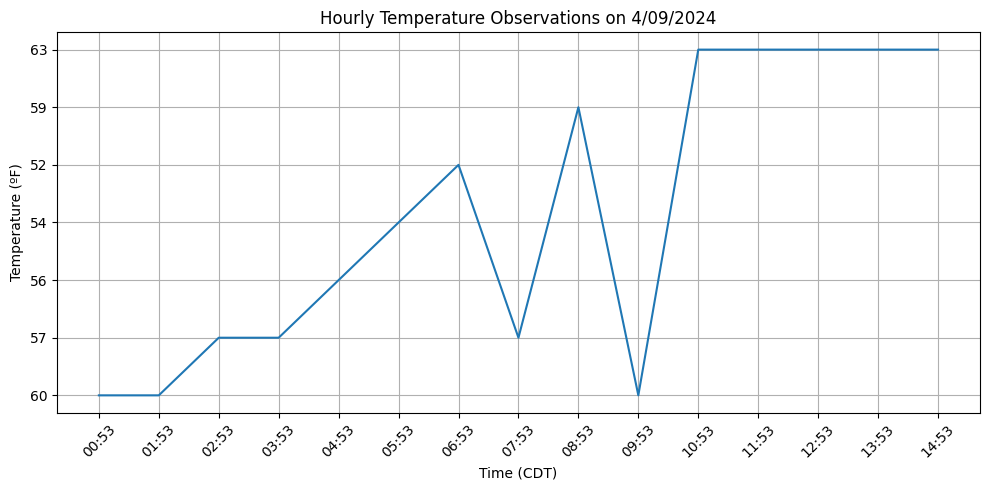

In [156]:
# Make a request to the website and get the content
url = "https://w1.weather.gov/data/obhistory/KMDW.html"
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find_all('table')[3]  # The data we need is in the 4th table on the page
rows = table.find_all('tr')
temperatures = []
for row in rows[2:]:  # The first few rows are headers, so we skip them
    columns = row.find_all('td')
    if len(columns) > 6:  # Ensure the row has enough columns
        date = columns[0].text
        time = columns[1].text
        temp = columns[6].text
        temperatures.append((date, time, temp))

# Convert to DataFrame
nws_data = pd.DataFrame(temperatures, columns=["Date", "Time", "Temperature (Air)"])
m = str(datetime.now().month)
nws_data['Datetime'] = pd.to_datetime(m + '-' + nws_data['Date'] + '-2024T' + nws_data['Time'])
t = str(datetime.now().day)
if int(t) < 10:
  t = '0' + t
y = str(datetime.now().year)
today = nws_data[nws_data["Date"] == t].sort_values(by = "Time")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(today['Time'], today['Temperature (Air)'])
plt.xlabel('Time (CDT)')
plt.ylabel('Temperature (ºF)')
plt.title("Hourly Temperature Observations on " + m + "/" + t + "/" + y)
plt.xticks(rotation=45)  #   Rotate x-axis labels for better visibility
plt.tight_layout()
plt.grid(True)
plt.show()

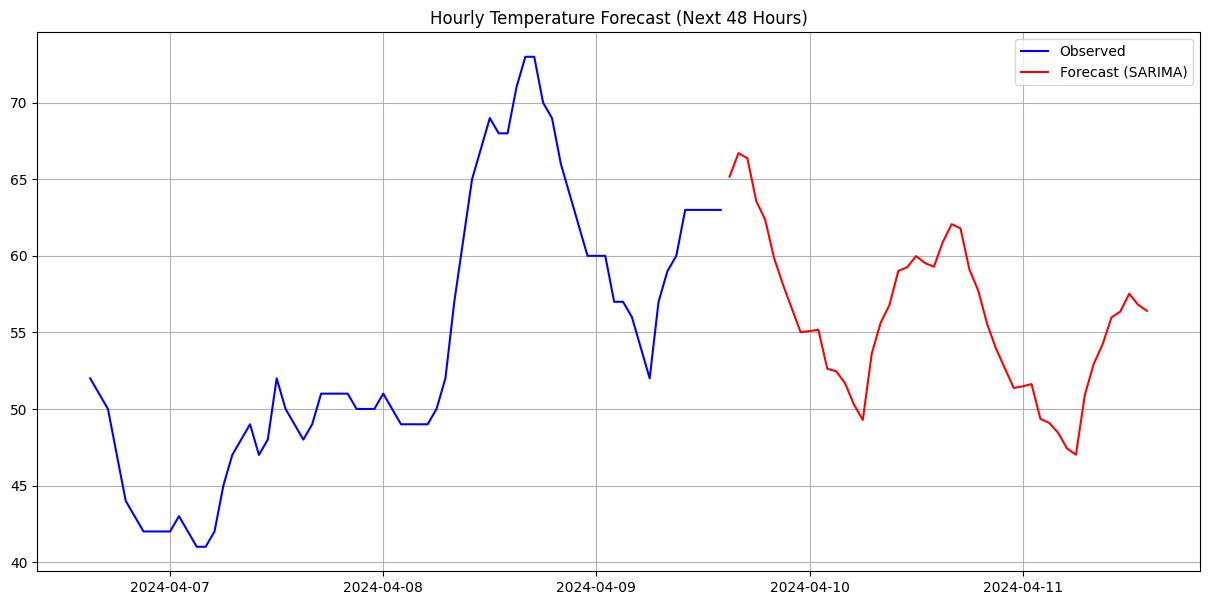

In [157]:
nws_data = nws_data.set_index("Datetime")
nws_data.index = nws_data.index.to_period('H')
nws_data = nws_data.sort_index(ascending=True)
nws_data['Temperature (Air)'] = pd.to_numeric(nws_data['Temperature (Air)'], errors='coerce')

warnings.filterwarnings("ignore", category=UserWarning)

# SARIMAX model for predicting the hourly temp for the next 48 hours
model = SARIMAX(nws_data['Temperature (Air)'], order=(5,1,0), seasonal_order=(1,1,1,24))
results = model.fit(disp=False)
nws_forecast = results.get_forecast(steps=48).predicted_mean
nws_forecast = pd.DataFrame(nws_forecast)

# Plotting
plt.figure(figsize=(15, 7))
observed_index = nws_data.index.to_timestamp()  # Plotting observed data
plt.plot(observed_index, nws_data['Temperature (Air)'], color='blue', label='Observed')
last_timestamp = observed_index[-1]
forecast_timestamps = [last_timestamp + np.timedelta64(i, 'h') for i in range(1, 49)]
nws_forecast.index = forecast_timestamps
plt.plot(forecast_timestamps, nws_forecast, color='red', label='Forecast (SARIMA)') # Plotting forecast values
plt.title('Hourly Temperature Forecast (Next 48 Hours)')
plt.legend()
plt.grid(True)
plt.show()

In [158]:
nws_forecast.head()

,predicted_mean
2024-04-09 15:00:00,65.170908
2024-04-09 16:00:00,66.708206
2024-04-09 17:00:00,66.377200
2024-04-09 18:00:00,63.585510
2024-04-09 19:00:00,62.367703


In [159]:
# Getting the maximum temperature for today and tomorrow
today = datetime.now().date()
today_forecast = nws_forecast[nws_forecast.index.date == today]
max_temp_today = today_forecast['predicted_mean'].max()
print(f"The maximum hourly temperature on {today} is {max_temp_today:.2f}°")

tomorrow = today + timedelta(days=1)
tomorrow_forecast = nws_forecast[nws_forecast.index.date == tomorrow]
max_temp_tomorrow = tomorrow_forecast['predicted_mean'].max()
print(f"The maximum hourly temperature on {tomorrow} is {max_temp_tomorrow:.2f}°")

The maximum hourly temperature on 2024-04-09 is 66.71°
The maximum hourly temperature on 2024-04-10 is 62.07°


### *Meteostat* (historical data)

Times retrieved from are in **Central Standard Time** (CST), which corresponds to CDT+1, therefore it should we converted.

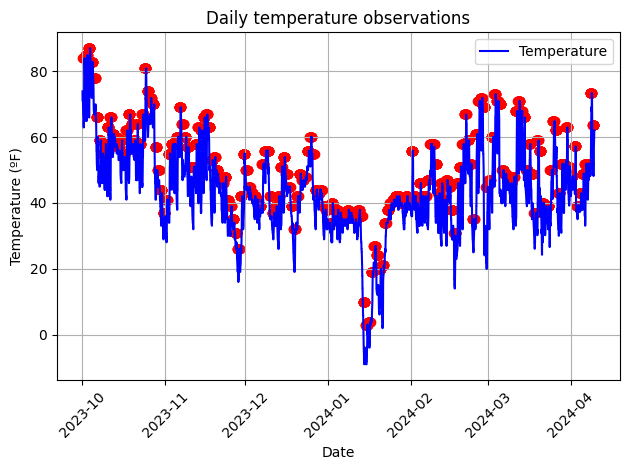

In [160]:
from meteostat import Hourly

start = datetime(2023, 10, 1)
end = datetime.now()
meteostat_data = Hourly('72534', start, end)
data_celsius = meteostat_data.fetch()
meteostat_data = (1.8 * data_celsius) + 32 #Convert to Fahrenheit

#Plotting
daily_max = meteostat_data.resample('D').max()
plt.plot(meteostat_data.index, meteostat_data['temp'], label='Temperature', color='blue')
for date, row in daily_max.iterrows():
    max_temp = row['temp']
    if not pd.isna(max_temp):  # Checking if max_temp is not NaN
        day_data = meteostat_data[meteostat_data.index.date == date.date()]
        plt.scatter(day_data.index, [max_temp]*len(day_data), color='red')
plt.xlabel('Date')
plt.ylabel('Temperature (ºF)')
plt.title('Daily temperature observations')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Exception in thread Thread-13 (fetch_data_periodically):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-117-6ebc4cf17efd>", line 21, in fetch_data_periodically
AttributeError: 'str' object has no attribute 'sleep'
Exception in thread Thread-12 (fetch_data_periodically):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-87-6ebc4cf17efd>", line 21, in fetch_data_periodically
AttributeError: 'str' object has no attribute 'sleep'
Exception in thread Thread-14 (fetch_data_periodically):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_i

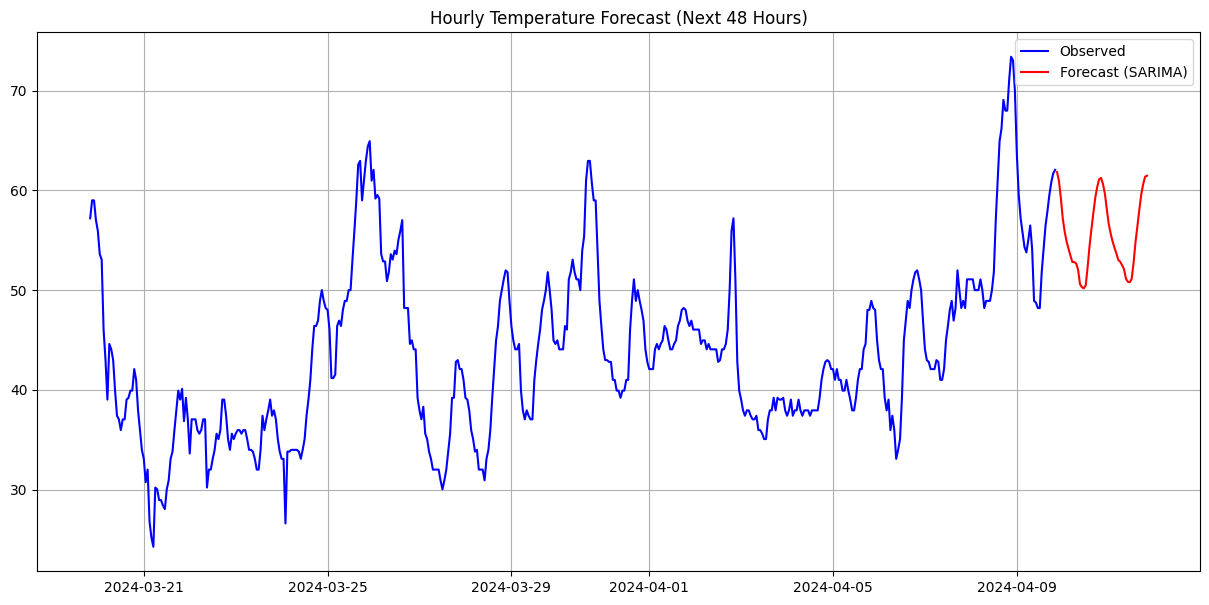

In [161]:
meteostat_data.index = pd.to_datetime(meteostat_data.index).to_period('H')

# Fitting ARIMA(5,1,0) model with seasonality(1,1,1,24)
model = SARIMAX(meteostat_data['temp'], order=(5,1,0), seasonal_order=(1,1,1,24))
results = model.fit(disp=False)

# Predicting the hourly temp for the next 48 hours
meteostat_forecast = results.get_forecast(steps=48).predicted_mean
meteostat_forecast = pd.DataFrame(meteostat_forecast)

# Filtering the last 3 weeks of observed data for the plot
three_weeks_ago = meteostat_data.index.to_timestamp().max() - pd.Timedelta(days=21)
filtered_data = meteostat_data[meteostat_data.index.to_timestamp() >= three_weeks_ago]

# Plotting
plt.figure(figsize=(15, 7))
observed_index_filtered = filtered_data.index.to_timestamp()  # Plotting observed data for the last 3 weeks
plt.plot(observed_index_filtered, filtered_data['temp'], color='blue', label='Observed')

# Assuming 'meteostat_forecast' contains the forecast starting after the last observed data point
forecast_index = pd.date_range(start=observed_index_filtered[-1] + np.timedelta64(1, 'h'), periods=48, freq='H')
plt.plot(forecast_index, meteostat_forecast, color='red', label='Forecast (SARIMA)') # Plotting forecast values
plt.title('Hourly Temperature Forecast (Next 48 Hours)')
plt.legend()
plt.grid(True)
plt.show()

In [162]:
meteostat_forecast.head()

,predicted_mean
2024-04-09 21:00,61.842483
2024-04-09 22:00,60.961585
2024-04-09 23:00,59.224559
2024-04-10 00:00,57.181085
2024-04-10 01:00,55.857437


In [163]:
# Merge the two dataframes
meteostat_forecast.index = meteostat_forecast.index.to_timestamp()
meteostat_forecast.index = meteostat_forecast.index.round('H')
nws_forecast.index = nws_forecast.index.round('H')

forecasts = meteostat_forecast.merge(nws_forecast, left_index=True, right_index=True, how='outer', suffixes=('_meteostat', '_nws'))
forecasts = pd.DataFrame(forecasts)
forecasts = forecasts.rename(columns={"predicted_mean_meteostat": "Meteostat", "predicted_mean_nws": "NWS (computed)"})

**Step 2: Comparison of the computed forecasts with real forecasts provided by the National Weather Service**

### *National Weather Service* (forecasts)

To ensure the predictions obtained with SARIMA on the NWS (historical) and Meteostat datasets are successful, they will be compared to the forecasts directly reported by the National Weather Service.

In [164]:
resp = requests.get("https://api.weather.gov/gridpoints/LOT/72,69/forecast/hourly")
if resp.status_code == 200:
    nws_forecast_actual = resp.json() # Parse the JSON response
else:
    print(f"Failed to retrieve data. Status code: {resp.status_code}")

# Extracting temperature, startTime values and dates
temperatures = [period['temperature'] for period in nws_forecast_actual['properties']['periods']]
starttimes_raw = [period['startTime'] for period in nws_forecast_actual['properties']['periods']]

# Extracting times and formatting
dates = []
hours = []
for raw_time in starttimes_raw:
    date_str, time_str = raw_time.split('T')
    time_str = time_str.split('-')[0]

    # Converting to datetime object to extract date and time components
    datetime_obj = datetime.fromisoformat(f"{date_str} {time_str}")

    # Extracting date and time
    extracted_date = datetime_obj.date()
    extracted_time = datetime_obj.time()

    dates.append(extracted_date)
    hours.append(extracted_time)

nws_forecast_actual_df = pd.DataFrame(columns = ["Date", "Time", "Temperature"])
nws_forecast_actual_df["Date"] = dates
nws_forecast_actual_df["Time"] = hours
nws_forecast_actual_df["Temperature"] = temperatures

#Storing data in "HourlyTempForecasts.csv". ONLY RUN IF YOU WANT TO SAVE FORECASTS.
'''
try:
    archive = pd.read_csv('HourlyTemps_Forecast.csv')
except FileNotFoundError:
    archive = pd.DataFrame(columns=['Date', 'Time', 'Temperature'])

warnings.filterwarnings("ignore", category=FutureWarning)
archive = pd.concat([archive, hourly_temps_forecast], ignore_index=True)
archive = archive.drop_duplicates(subset=["Date", "Time"], keep='last')
archive.to_csv('HourlyTemps_Forecast.csv', index=False)
print("Hourly temperature forecasts saved in HourlyTemps_Forecast.csv.")
'''

#Getting the maximum hourly temperature for today and tomorrow.
today_temp_forecast = nws_forecast_actual_df[nws_forecast_actual_df["Date"] == today]#datetime.now().date()
max_temp_today = max(today_temp_forecast["Temperature"])
print("The maximum hourly temperature today in Chicago Midway Airport is forecasted to be", max_temp_today, "degrees by the NWS.")

tomorrow_temp_forecast = nws_forecast_actual_df[nws_forecast_actual_df["Date"] == tomorrow]#datetime.now().date() + timedelta(days=1)]
max_temp_tomorrow = max(tomorrow_temp_forecast["Temperature"])
print("The maximum hourly temperature tomorrow in Chicago Midway Airport is forecasted to be", max_temp_tomorrow, "degrees by the NWS.")

The maximum hourly temperature today in Chicago Midway Airport is forecasted to be 63 degrees by the NWS.
The maximum hourly temperature tomorrow in Chicago Midway Airport is forecasted to be 65 degrees by the NWS.


In [165]:
nws_forecast_actual_df = nws_forecast_actual_df[2:]
nws_forecast_actual_df.head(5)

,Date,Time,Temperature
2,2024-04-09,17:00:00,62
3,2024-04-09,18:00:00,61
4,2024-04-09,19:00:00,59
5,2024-04-09,20:00:00,57
6,2024-04-09,21:00:00,54


In [167]:
nws_forecast_actual_df['datetime'] = pd.to_datetime(nws_forecast_actual_df['Date'].astype(str) + ' ' + nws_forecast_actual_df['Time'].astype(str))
nws_forecast_actual_df.set_index('datetime', inplace=True)
nws_forecast_actual_df.drop(columns=['Date', 'Time'], inplace=True)
nws_forecast_actual_df.index = nws_forecast_actual_df.index.round('H')
combined_forecasts = forecasts.merge(nws_forecast_actual_df, left_index=True, right_index=True, how='outer')
combined_forecasts = combined_forecasts.rename(columns={"Temperature": "NWS (official)"})
combined_forecasts = combined_forecasts[6:56]
combined_forecasts

,Meteostat,NWS (computed),NWS (official)
2024-04-09 21:00:00,61.842483,58.139355,54.0
2024-04-09 22:00:00,60.961585,56.570983,52.0
2024-04-09 23:00:00,59.224559,55.013446,51.0
2024-04-10 00:00:00,57.181085,55.080686,50.0
2024-04-10 01:00:00,55.857437,55.173658,48.0
2024-04-10 02:00:00,54.875416,52.627876,48.0
2024-04-10 03:00:00,54.147432,52.462927,46.0
2024-04-10 04:00:00,53.462369,51.683615,46.0
2024-04-10 05:00:00,52.820471,50.292327,45.0
2024-04-10 06:00:00,52.809695,49.286244,44.0


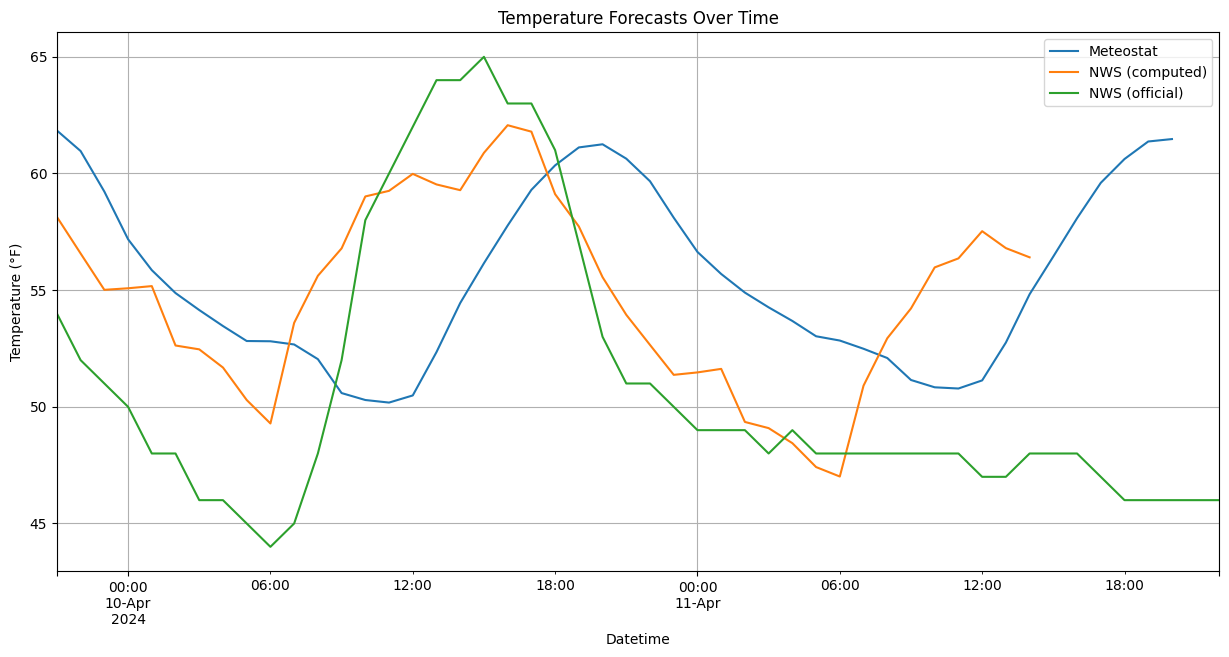

In [168]:
# Plotting
plt.figure(figsize=(15, 7))
for column in combined_forecasts.columns:
    combined_forecasts[column].plot(label=column)

plt.title('Temperature Forecasts Over Time')
plt.xlabel('Datetime')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True)
plt.show()

As observed in the graph, the forecasts obtained with SARIMA using historical data from both the NWS and Meteostat do not adjust well to the official forecasts provided by the NWS.

**Step 3: Automatic purchases of "Yes" contracts on forecasted maximum temperature**

Given that the computed predictions with SARIMA on the NWS and Meteostat's historical datasets are not reliable, the official forecasts provided by the NWS will be employed to purchase the contracts.

In [169]:
#import KalshiClientsBaseV2
#from KalshiClientsBaseV2 import ExchangeClient

import requests
import json
from datetime import datetime as dt
from urllib3.exceptions import HTTPError
from dateutil import parser
from typing import Any, Dict, List, Optional, Tuple
from datetime import datetime
from datetime import timedelta
import time


class KalshiClient:
    """A simple client that allows utils to call authenticated Kalshi API endpoints."""
    def __init__(
        self,
        host: str,
        email: str,
        password: str,
        token: Optional[str] = None,
        user_id: Optional[str] = None,
    ):
        """Initializes the client and logs in the specified user.
        Raises an HttpError if the user could not be authenticated.
        """

        self.host = host
        self.email = email
        self.password = password
        self.token = token
        self.user_id = user_id
        self.last_api_call = datetime.now()

    """Built in rate-limiter. We STRONGLY encourage you to keep
    some sort of rate limiting, just in case there is a bug in your
    code. Feel free to adjust the threshold"""
    def rate_limit(self) -> None:
        # Adjust time between each api call
        THRESHOLD_IN_MILLISECONDS = 100

        now = datetime.now()
        threshold_in_microseconds = 1000 * THRESHOLD_IN_MILLISECONDS
        threshold_in_seconds = THRESHOLD_IN_MILLISECONDS / 1000
        if now - self.last_api_call < timedelta(microseconds=threshold_in_microseconds):
            time.sleep(threshold_in_seconds)
        self.last_api_call = datetime.now()

    def post(self, path: str, body: dict) -> Any:
        """POSTs to an authenticated Kalshi HTTP endpoint.
        Returns the response body. Raises an HttpError on non-2XX results.
        """
        self.rate_limit()

        response = requests.post(
            self.host + path, data=body, headers=self.request_headers()
        )
        self.raise_if_bad_response(response)
        return response.json()

    def get(self, path: str, params: Dict[str, Any] = {}) -> Any:
        """GETs from an authenticated Kalshi HTTP endpoint.
        Returns the response body. Raises an HttpError on non-2XX results."""
        self.rate_limit()

        response = requests.get(
            self.host + path, headers=self.request_headers(), params=params
        )
        self.raise_if_bad_response(response)
        return response.json()

    def delete(self, path: str, params: Dict[str, Any] = {}) -> Any:
        """Posts from an authenticated Kalshi HTTP endpoint.
        Returns the response body. Raises an HttpError on non-2XX results."""
        self.rate_limit()

        response = requests.delete(
            self.host + path, headers=self.request_headers(), params=params
        )
        self.raise_if_bad_response(response)
        return response.json()

    def request_headers(self) -> Dict[str, Any]:
        headers = {"Content-Type": "application/json"}
        if self.token:
            headers["Authorization"] = self.user_id + " " + self.token
        return headers

    def raise_if_bad_response(self, response: requests.Response) -> None:
        if response.status_code not in range(200, 299):
            raise HttpError(response.reason, response.status_code)

    def query_generation(self, params:dict) -> str:
        relevant_params = {k:v for k,v in params.items() if v != None}
        if len(relevant_params):
            query = '?'+''.join("&"+str(k)+"="+str(v) for k,v in relevant_params.items())[1:]
        else:
            query = ''
        return query

class HttpError(Exception):
    """Represents an HTTP error with reason and status code."""
    def __init__(self, reason: str, status: int):
        super().__init__(reason)
        self.reason = reason
        self.status = status

    def __str__(self) -> str:
        return "HttpError(%d %s)" % (self.status, self.reason)

class ExchangeClient(KalshiClient):
    def __init__(self,
                    exchange_api_base: str,
                    email: str,
                    password: str):
        super().__init__(
            exchange_api_base,
            email,
            password,
        )

        """You must log in before making authenticated calls. We store the token and
        pass it into each call."""

        login_json = json.dumps({"email": self.email, "password": self.password})
        result = self.post(path = "/login", body = login_json)
        self.token = result["token"]
        self.user_id = result["member_id"]

        self.exchange_url = "/exchange"
        self.markets_url = "/markets"
        self.events_url = "/events"
        self.series_url = "/series"
        self.portfolio_url = "/portfolio"

    def logout(self,):
        result = self.post("/logout")
        return result

    def get_exchange_status(self,):
        result = self.get(self.exchange_url + "/status")
        return result

    # market endpoints!

    def get_markets(self,
                        limit:Optional[int]=None,
                        cursor:Optional[str]=None,
                        event_ticker:Optional[str]=None,
                        series_ticker:Optional[str]=None,
                        max_close_ts:Optional[int]=None,
                        min_close_ts:Optional[int]=None,
                        status:Optional[str]=None,
                        tickers:Optional[str]=None,
                            ):
        query_string = self.query_generation(params={k: v for k,v in locals().items()})
        dictr = self.get(self.markets_url+query_string)
        return dictr

    def get_market_url(self,
                        ticker:str):
        return self.markets_url+'/'+ticker

    def get_market(self,
                    ticker:str):
        market_url = self.get_market_url(ticker=ticker)
        dictr = self.get(market_url)
        return dictr

    def get_event(self,
                    event_ticker:str):
        dictr = self.get(self.events_url+'/'+event_ticker)
        return dictr

    def get_series(self,
                    series_ticker:str):
        dictr = self.get(self.series_url+'/'+series_ticker)
        return dictr

    def get_market_history(self,
                            ticker:str,
                            limit:Optional[int]=None,
                            cursor:Optional[str]=None,
                            max_ts:Optional[int]=None,
                            min_ts:Optional[int]=None,
                            ):
        relevant_params = {k: v for k,v in locals().items() if k!= 'ticker'}
        query_string = self.query_generation(params = relevant_params)
        market_url = self.get_market_url(ticker = ticker)
        dictr = self.get(market_url + '/history' + query_string)
        return dictr

    def get_orderbook(self,
                        ticker:str,
                        depth:Optional[int]=None,
                        ):
        relevant_params = {k: v for k,v in locals().items() if k!= 'ticker'}
        query_string = self.query_generation(params = relevant_params)
        market_url = self.get_market_url(ticker = ticker)
        dictr = self.get(market_url + "/orderbook" + query_string)
        return dictr

    def get_trades(self,
                    ticker:Optional[str]=None,
                    limit:Optional[int]=None,
                    cursor:Optional[str]=None,
                    max_ts:Optional[int]=None,
                    min_ts:Optional[int]=None,
                    ):
        query_string = self.query_generation(params={k: v for k,v in locals().items()})
        if ticker != None:
            if len(query_string):
                query_string += '&'
            else:
                query_string += '?'
            query_string += "ticker="+str(ticker)

        trades_url = self.markets_url + '/trades'
        dictr = self.get(trades_url + query_string)
        return dictr

    # portfolio endpoints!

    def get_balance(self,):
        dictr = self.get(self.portfolio_url+'/balance')
        return dictr

    def create_order(self,
                        ticker:str,
                        client_order_id:str,
                        side:str,
                        action:str,
                        count:int,
                        type:str,
                        yes_price:Optional[int]=None,
                        no_price:Optional[int]=None,
                        expiration_ts:Optional[int]=None,
                        sell_position_floor:Optional[int]=None,
                        buy_max_cost:Optional[int]=None,
                        ):

        relevant_params = {k: v for k,v in locals().items() if k != 'self' and v != None}

        print(relevant_params)
        order_json = json.dumps(relevant_params)
        orders_url = self.portfolio_url + '/orders'
        result = self.post(path = orders_url, body = order_json)
        return result

    def batch_create_orders(self,
                                orders:list
        ):
        orders_json = json.dumps({'orders': orders})
        batched_orders_url = self.portfolio_url + '/orders/batched'
        result = self.post(path = batched_orders_url, body = orders_json)
        return result

    def decrease_order(self,
                        order_id:str,
                        reduce_by:int,
                        ):
        order_url = self.portfolio_url + '/orders/' + order_id
        decrease_json = json.dumps({'reduce_by': reduce_by})
        result = self.post(path = order_url + '/decrease', body = decrease_json)
        return result

    def cancel_order(self,
                        order_id:str):
        order_url = self.portfolio_url + '/orders/' + order_id
        result = self.delete(path = order_url + '/cancel')
        return result

    def batch_cancel_orders(self,
                                order_ids:list
        ):
        order_ids_json = json.dumps({"ids":order_ids})
        batched_orders_url = self.portfolio_url + '/orders/batched'
        result = self.delete(path = batched_orders_url, body = order_ids_json)
        return result

    def get_fills(self,
                        ticker:Optional[str]=None,
                        order_id:Optional[str]=None,
                        min_ts:Optional[int]=None,
                        max_ts:Optional[int]=None,
                        limit:Optional[int]=None,
                        cursor:Optional[str]=None):

        fills_url = self.portfolio_url + '/fills'
        query_string = self.query_generation(params={k: v for k,v in locals().items()})
        dictr = self.get(fills_url + query_string)
        return dictr

    def get_orders(self,
                        ticker:Optional[str]=None,
                        event_ticker:Optional[str]=None,
                        min_ts:Optional[int]=None,
                        max_ts:Optional[int]=None,
                        limit:Optional[int]=None,
                        cursor:Optional[str]=None
                        ):
        orders_url = self.portfolio_url + '/orders'
        query_string = self.query_generation(params={k: v for k,v in locals().items()})
        dictr = self.get(orders_url + query_string)
        return dictr

    def get_order(self,
                    order_id:str):
        orders_url = self.portfolio_url + '/orders'
        dictr = self.get(orders_url + '/' +  order_id)
        return dictr

    def get_positions(self,
                        limit:Optional[int]=None,
                        cursor:Optional[str]=None,
                        settlement_status:Optional[str]=None,
                        ticker:Optional[str]=None,
                        event_ticker:Optional[str]=None,
                        ):
        positions_url = self.portfolio_url + '/positions'
        query_string = self.query_generation(params={k: v for k,v in locals().items()})
        dictr = self.get(positions_url + query_string)
        return dictr

    def get_portfolio_settlements(self,
                                    limit:Optional[int]=None,
                                    cursor:Optional[str]=None,):

        positions_url = self.portfolio_url + '/settlements'
        query_string = self.query_generation(params={k: v for k,v in locals().items()})
        dictr = self.get(positions_url + query_string)
        return dictr

In [170]:
#Logging into kalshi.com
demo_email = "cpelayo@bu.edu" #SUBSTITUTE WITH YOUR OWN USERNAME
demo_password = "Abcdefg12345!" #SUBSTITUTE WITH YOUR OWN PASSWORD
demo_api_base = "https://demo-api.kalshi.co/trade-api/v2"

exchange_client = ExchangeClient(exchange_api_base = demo_api_base, email = demo_email, password = demo_password)

print(exchange_client.get_exchange_status())

{'exchange_active': True, 'trading_active': True}


In [171]:
#Inspecting the current HIGHCHI market
market_params = {'limit':100,
                 'cursor':None, # passing in the cursor from the previous get_markets call
                 'event_ticker': None,
                 'series_ticker':"HIGHCHI",
                 'max_close_ts':None, # pass in unix_ts
                 'min_close_ts':None, # pass in unix_ts
                 'status':None,
                 'tickers':None}

markets_response = exchange_client.get_markets(**market_params)
markets = markets_response["markets"]
cursor = markets_response['cursor']
tomorrow_market = pd.DataFrame(markets)[:6]
today_market = pd.DataFrame(markets)[6:12]

*Purchase order for current day*

In [173]:
#ONLY UNCOMMENT WHEN READY TO CREATE A TRANSACTION
'''
#Creating purchase order
ticker = [x for x in today_market["ticker"].values if str(max_temp_today) in x else ][0]
count = 100 #Adjust as preferred
yes_price = 1 #today_market[today_market["ticker"] == ticker]["yes_bid"].iloc[0] #Price for today
todaymaxtemp = str(max_temp_today)

found = False
while not found:
    for val in today_market["ticker"].values:
        if todaymaxtemp in val:
            ticker = val
            found = True
            break
    if not found:
        todaymaxtemp = str(int(todaymaxtemp) - 1)

order_params = {'ticker': ticker,
                'client_order_id':str(uuid.uuid4()),
                'type':'limit',
                'action':'buy',
                'side':'yes',
                'count': count, #SUBSTITUTE WITH NUMBER OF AVAILABLE CONTRACTS AT THE MOMENT OF PURCHASE
                'yes_price': yes_price, #SUBSTITUTE WITH PRICE AT THE MOMENT OF PURCHASE
                'no_price':None,
                'expiration_ts':None,
                'sell_position_floor':None,
                'buy_max_cost':None}

exchange_client.create_order(**order_params)
print("The maximum temperature forecasted today is", todaymaxtemp, "ºF, thus the order of", count, "'Yes' contracts at", yes_price,"cents on event", ticker, "was sucessfully processed.")
'''

'\n#Creating purchase order\nticker = [x for x in today_market["ticker"].values if str(max_temp_today) in x else ][0]\ncount = 100 #Adjust as preferred\nyes_price = 1 #today_market[today_market["ticker"] == ticker]["yes_bid"].iloc[0] #Price for today\ntodaymaxtemp = str(max_temp_today)\n\nfound = False\nwhile not found:\n    for val in today_market["ticker"].values:\n        if todaymaxtemp in val:\n            ticker = val\n            found = True\n            break\n    if not found:\n        todaymaxtemp = str(int(todaymaxtemp) - 1)\n\norder_params = {\'ticker\': ticker,\n                \'client_order_id\':str(uuid.uuid4()),\n                \'type\':\'limit\',\n                \'action\':\'buy\',\n                \'side\':\'yes\',\n                \'count\': count, #SUBSTITUTE WITH NUMBER OF AVAILABLE CONTRACTS AT THE MOMENT OF PURCHASE\n                \'yes_price\': yes_price, #SUBSTITUTE WITH PRICE AT THE MOMENT OF PURCHASE\n                \'no_price\':None,\n                

*Purchase order for next day*

In [174]:
#ONLY UNCOMMENT WHEN READY TO CREATE A TRANSACTION
'''
#Creating purchase order
ticker = [x for x in tomorrow_market["ticker"].values if str(max_temp_tomorrow) in x][0]
count = 100 #Adjust as preferred
yes_price = 1 #tomorrow_market[tomorrow_market["ticker"] == ticker]["yes_bid"].iloc[0] #Price for today
tomorrowmaxtemp = str(max_temp_tomorrow)

found = False
while not found:
    for val in tomorrow_market["ticker"].values:
        if tomorrowmaxtemp in val:
            ticker = val
            found = True
            break
    if not found:
        tomorrowmaxtemp = str(int(tomorrowmaxtemp) - 1)

order_params = {'ticker': ticker,
                'client_order_id':str(uuid.uuid4()),
                'type':'limit',
                'action':'buy',
                'side':'yes',
                'count': count, #SUBSTITUTE WITH NUMBER OF AVAILABLE CONTRACTS AT THE MOMENT OF PURCHASE
                'yes_price': yes_price, #SUBSTITUTE WITH PRICE AT THE MOMENT OF PURCHASE
                'no_price':None,
                'expiration_ts':None,
                'sell_position_floor':None,
                'buy_max_cost':None}

exchange_client.create_order(**order_params)
print("The maximum temperature forecasted tomorrow is", tomorrowmaxtemp, "ºF, thus the order of", count, "'Yes' contracts at", yes_price,"cents on event", ticker, "was sucessfully processed.")
'''

'\n#Creating purchase order\nticker = [x for x in tomorrow_market["ticker"].values if str(max_temp_tomorrow) in x][0]\ncount = 100 #Adjust as preferred\nyes_price = 1 #tomorrow_market[tomorrow_market["ticker"] == ticker]["yes_bid"].iloc[0] #Price for today\ntomorrowmaxtemp = str(max_temp_tomorrow)\n\nfound = False\nwhile not found:\n    for val in tomorrow_market["ticker"].values:\n        if tomorrowmaxtemp in val:\n            ticker = val\n            found = True\n            break\n    if not found:\n        tomorrowmaxtemp = str(int(tomorrowmaxtemp) - 1)\n\norder_params = {\'ticker\': ticker,\n                \'client_order_id\':str(uuid.uuid4()),\n                \'type\':\'limit\',\n                \'action\':\'buy\',\n                \'side\':\'yes\',\n                \'count\': count, #SUBSTITUTE WITH NUMBER OF AVAILABLE CONTRACTS AT THE MOMENT OF PURCHASE\n                \'yes_price\': yes_price, #SUBSTITUTE WITH PRICE AT THE MOMENT OF PURCHASE\n                \'no_price\'

# Strategy 2

The program for Strategy 2 aims to obtain the exact minute when the forecasted maximum temperature in a day is reached, so that it can instantly trigger a purchase of "No" contracts for the temperature immediately below that one.

*Please run this part of the notebook when possible to optimize revenue by leveraging minute data. See the required runtime for each day below.*

In [175]:
warnings.filterwarnings("ignore", category=FutureWarning)
hour = str(today_temp_forecast[today_temp_forecast["Temperature"] == max_temp_today].iloc[0][["Time"]][0])
date = str(today_temp_forecast[today_temp_forecast["Temperature"] == max_temp_today].iloc[0][["Date"]][0])
print("This program should run 60 minutes before", hour, "CDT on", date, " to invest in today's market.")

hour_tom = str(tomorrow_temp_forecast[tomorrow_temp_forecast["Temperature"] == max_temp_tomorrow].iloc[0][["Time"]][0])
date_tom = str(tomorrow_temp_forecast[tomorrow_temp_forecast["Temperature"] == max_temp_tomorrow].iloc[0][["Date"]][0])
print("This program should run 60 minutes before", hour_tom, "CDT on", date_tom, "to invest in tomorrow's market.")

This program should run 60 minutes before 15:00:00 CDT on 2024-04-09  to invest in today's market.
This program should run 60 minutes before 15:00:00 CDT on 2024-04-10 to invest in tomorrow's market.


Data is obtained from **OpenWeather**. It offers 1000 free API calls per day on weather forecasts of:
*   Current weather data on temperature, precipitations, etc.
*   Minutely forecasts on precipitations (MM:00 during the next 60 minutes after the API is called ): precipitation (mm/h).
*   Hourly forecasts on various weather parameters (HH<:00:00 during the next 47 hours after the API is called): temp, rain (mm/h), humidity, etc.

The resulting times are in the UTC timezone (CDT is UTC-4).

To determine whether Strategy 2.1 (which relies on precipitation data) or Strategy 2.2, we need to **observe whether it will rain in Chicago**. For that, precipitation forecasts by OpenWeather will be used. When the correlation between hourly temperatures and hourly precipitations that day exceeds 80% (negative correlation), it will be assumed that the relationship between the variables is significant and thus temperatures can be inferred with a high degree of reliability.

In [176]:
import math

warnings.filterwarnings("ignore", category=RuntimeWarning)
try:
    resp = requests.get("https://api.openweathermap.org/data/3.0/onecall?lat=41.79&lon=-87.75&appid=316c5056b28e34f4c4f782d1d48a8c8c&units=imperial")
    if resp.status_code == 200:
        ow_forecast = resp.json() # Parse the JSON response
    else:
        print(f"Failed to retrieve data. Status code: {resp.status_code}")
except Exception as e:
    print(f"Error occurred: {e}")

# Minutely precipitations
minutely_rain = ow_forecast["minutely"] #Selecting the dict on minutely data within the JSON dict of dicts.
minutely_rain = pd.DataFrame.from_dict(minutely_rain) #Converting the JSON dict on minutely data into a Pandas DataFrame.
minutely_rain['datetime'] = pd.to_datetime(minutely_rain['dt'], unit='s').dt.tz_localize('UTC') #Converting UNIX datestamps to GMT timestamps.
minutely_rain['date'] = minutely_rain['datetime'].dt.date
minutely_rain['time'] = minutely_rain['datetime'].dt.time
minutely_rain = minutely_rain[["datetime", "date", "time", "precipitation"]].rename(columns={"precipitation": "rain"}).fillna(0)

# Hourly temperatures
hourly_data = ow_forecast["hourly"] #Selecting the dict on hourly data within the JSON dict of dicts.
hourly_data = pd.DataFrame.from_dict(hourly_data) #Converting the JSON dict on minutely data into a Pandas DataFrame.
hourly_data["datetime"] = pd.to_datetime(hourly_data["dt"], unit='s').dt.tz_localize("UTC") #Converting UNIX datestamps to GMT timestamps.
hourly_data['date'] = hourly_data['datetime'].dt.date
hourly_data['time'] = hourly_data['datetime'].dt.time
hourly_data = hourly_data[["datetime", "date", "time", "temp", "uvi", "humidity", "pop"]].fillna(0) #Selecting the parameters we're interested in

today_hourly_temps = hourly_data[hourly_data["date"] == datetime.now().date()]["temp"]
today_hourly_rains = hourly_data[hourly_data["date"] == datetime.now().date()]["pop"]

# Check is strategy 1 may be used (i.e. if there is enough precipitation data to infer minute temperatures)
correlation = today_hourly_temps.corr(today_hourly_rains)
if math.isnan(correlation):
    correlation = 0
print("The correlation between temperatures and precipitations in the next 60 minutes is forecasted at", correlation, ".")
if correlation > 0.8 or correlation < -0.8:
    print("You can thus use Strategy 2.1 as there is significant evidence of precipitations in Chicago Midway International Airport.")
else:
    print("You need to use Strategy 2.2 as there is not significant evidence of precipitations in Chicago Midway International Airport.")

The correlation between temperatures and precipitations in the next 60 minutes is forecasted at 0 .
You need to use Strategy 2.2 as there is not significant evidence of precipitations in Chicago Midway International Airport.


## Strategy 2.1

In strategy 2.1, the minute when the forecasted maximum temperature in a day is reached is predicted by applying a Random Forest Regressor on minute forecasts of precipitations.

*Please note: if it is not currently raining in Chicago, the graph will be odd. Please check again when Strategy 2.1 is recommended to use. In the meantime, you can check the notebook ***"MinuteTemperaturesInferenceExample.ipynb"***, as reference on how the graph looks like while it is raining in Chicago.*

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


No predicted temperature values close to the mean temperature.


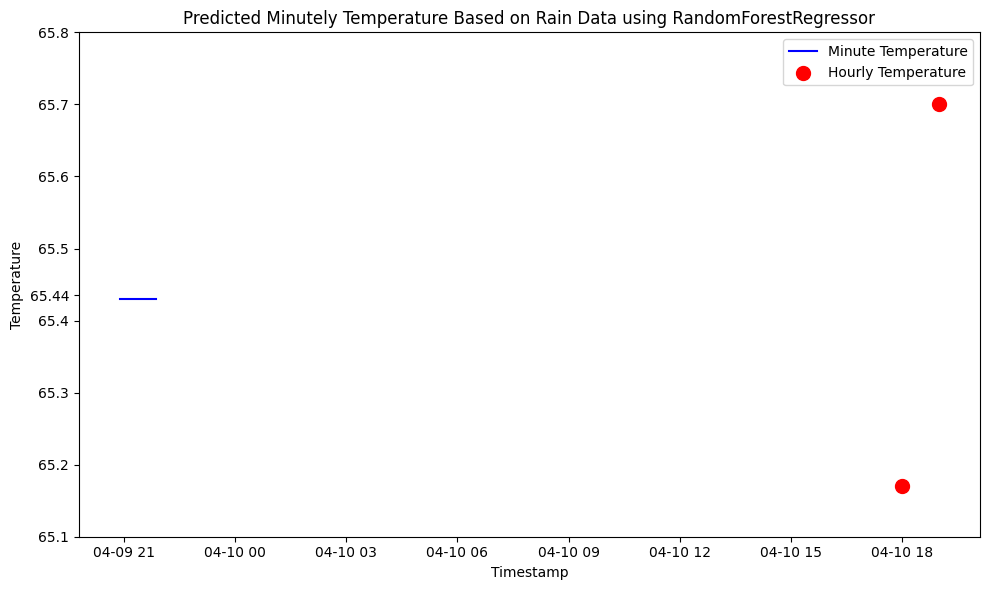

In [177]:
minutely_rain = minutely_rain[:-1]
specific_day = datetime.today().date() + timedelta(days=1)
specific_day = specific_day.strftime('%Y-%m-%d')
selected_data = hourly_data[hourly_data['datetime'].dt.date == pd.Timestamp(specific_day).date()]
hottesthour = selected_data[selected_data["temp"] == selected_data["temp"].max()].index
idx = hottesthour.to_list()[0]
hottest_range = hourly_data.iloc[idx-1:idx+1]

from sklearn.ensemble import RandomForestRegressor

# Make a copy to avoid warnings about modifying slices
hottest_range = hottest_range.copy()
hottest_range['datetime'] = pd.to_datetime(hottest_range['datetime'])
hottest_range.set_index('datetime', inplace=True)
minutely_rain['datetime'] = pd.to_datetime(minutely_rain['datetime'])

# Convert temperature to float type and then interpolate
hottest_range['temp'] = hottest_range['temp'].astype(float)
minutely_temp = hottest_range.resample('T').interpolate(method='linear').reset_index()
X = minutely_rain[['rain']]
y = minutely_temp['temp']

# Ensure consistent length of X and y
if len(X) > len(y):
    X = X.iloc[:len(y)]
elif len(X) < len(y):
    y = y.iloc[:len(X)]

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Predict the minutely temperatures based on rain data
predicted_temps = model.predict(X)

# Compute the mean of the temperatures in hottest_range
mean_temperature = hottest_range['temp'].mean()

# Identify the index where the temperature is close to the mean
tolerance = 0.001
indices_near_mean = np.where(np.abs(predicted_temps - mean_temperature) <= tolerance)[0]
if len(indices_near_mean) > 0:
    median_temp_reached_index = indices_near_mean[0]
    median_temp_reached_timestamp = minutely_rain.iloc[median_temp_reached_index]['datetime']
else:
    median_temp_reached_index = None
    median_temp_reached_timestamp = None
    print("No predicted temperature values close to the mean temperature.")

# Plotting
plt.figure(figsize=(10,6))
plt.plot(minutely_rain['datetime'], predicted_temps, label="Minute Temperature", color='blue')
plt.scatter(hottest_range.index, hottest_range['temp'], color='red', label="Hourly Temperature", s=100)

# Adjusting the y-ticks to include the mean_temperature specifically
yticks = plt.gca().get_yticks()
yticks = np.append(yticks, mean_temperature)
plt.gca().set_yticks(yticks)
plt.gca().set_yticklabels([str(round(ytick, 2)) if ytick != mean_temperature else f'{mean_temperature:.2f}' for ytick in yticks])

if median_temp_reached_index:
    # Compute fractions for line lengths
    y_fraction = (mean_temperature - hottest_range.iloc[0]['temp']) / (hottest_range.iloc[1]['temp'] - hottest_range.iloc[0]['temp'])
    x_fraction = (median_temp_reached_timestamp - minutely_rain.iloc[0]['datetime']).seconds / 3600

    # Adding the limited horizontal and vertical lines
    plt.axhline(y=mean_temperature, xmin=0, xmax=x_fraction, color='green', linestyle='--')
    plt.axvline(x=median_temp_reached_timestamp, ymin=0, ymax=y_fraction, color='purple', linestyle='--')

plt.xlabel("Timestamp")
plt.ylabel("Temperature")
plt.title("Predicted Minutely Temperature Based on Rain Data using RandomForestRegressor")
plt.legend()
plt.tight_layout()
plt.show()

if median_temp_reached_timestamp:
    print(f"The mean temperature of {mean_temperature:.2f}°C is first reached at: {median_temp_reached_timestamp}")

## Strategy 2.2

The program for Strategy 2.2. **automatically retrieves the latest current temperature data available every 60 seconds** from OpenWeather. This process starts running when the notebook is first run and will stop when the kernel is interrupted.

In [178]:
#PAUSE THIS CODE WHEN ENOUGH MINUTE DATA IS GATHERED (OTHERWISE IT WILL RUN INFINITELY!)

import threading
import queue
import time
from datetime import timedelta

data_queue = queue.Queue()
round_count = 0

# Defining the thread function that fetches the data periodically
def fetch_data_periodically(interval_seconds):
    while True:
        try:
            resp = requests.get("https://api.openweathermap.org/data/3.0/onecall?lat=41.79&lon=-87.75&appid=316c5056b28e34f4c4f782d1d48a8c8c&units=imperial")
            if resp.status_code == 200:
                data = resp.json() # Parse the JSON response
                data_queue.put(data)
            else:
                print(f"Failed to retrieve data. Status code: {resp.status_code}")
        except Exception as e:
            print(f"Error occurred: {e}")
        time.sleep(interval_seconds)

# Starting the background thread
thread = threading.Thread(target=fetch_data_periodically, args=(60,))
thread.daemon = True  # This ensures the thread will exit when the main program exits
thread.start()

last_fetched_time = None

try:
    print("Today, the maximum temperature in Chicago was forecasted at", todaymaxtemp, "degrees according to the NWS.")
    while True:
        data = data_queue.get()
        #round_count += 1

        #Fetching the current minute's temperature in Chicago
        current_data = data["current"]
        current_data = pd.DataFrame.from_dict(current_data) #Converting the JSON dict on minutely data into a Pandas DataFrame.
        current_data["datetime"] = pd.to_datetime(current_data["dt"], unit='s').dt.tz_localize("UTC") - timedelta(hours=5)#Converting UNIX datestamps to GMT timestamps.
        current_data['date'] = current_data['datetime'].dt.date
        current_data['time'] = current_data['datetime'].dt.time
        current_data = current_data[["date", "time", "temp"]]

        current_timestamp = (current_data['date'][0], current_data['time'][0])
        if current_timestamp != last_fetched_time:
            last_fetched_time = current_timestamp

            #Storing data in "MinutelyTemps_Historical.csv"
            '''
            try:
                archive = pd.read_csv('MinuteTemps_Historical.csv')
            except FileNotFoundError:
                archive = pd.DataFrame(columns=['Date', 'Time', 'Temperature'])
            api_call = pd.DataFrame({'Date': [current_data['date'][0]], 'Time': [current_data['time'][0]], 'Temperature': [current_data['temp'][0]]})
            warnings.filterwarnings("ignore", category=FutureWarning)
            archive = pd.concat([archive, api_call], ignore_index=True)
            archive.to_csv('MinuteTemps_Historical.csv', index=False)
            '''
            print("At", current_data['time'][0], "CST on", current_data['date'][0], "the temperature in Chicago Midway International Airport is", current_data['temp'][0], "Fahrenheit degrees.")
            if current_data['temp'][0] > int(todaymaxtemp)-0.5:
                print("The maximum temperature for today was reached. Contracts will now be purchased.")
                break

except KeyboardInterrupt:
    print("The program was interrupted.")

Today, the maximum temperature in Chicago was forecasted at 64 degrees according to the NWS.
At 15:52:42 CST on 2024-04-09 the temperature in Chicago Midway International Airport is 63.36 Fahrenheit degrees.
The program was interrupted.


In [179]:
# ONLY UNCOMMENT WHEN READY TO CREATE A TRANSACTION
'''
# Creating purchase order
prev_temp = str(int(todaymaxtemp) - 1) #Immediately lower temp to the maximum
found = False
while not found:
    for val in today_market["ticker"].values:
        if prev_temp in val:
            ticker = val
            found = True
            break
    if not found:
        prev_temp = str(int(prev_temp) - 1)

count = 100 #Adjust as preferred
try:
    no_price = 1 #today_market[today_market["ticker"] == ticker]["no_bid"].iloc[0] #Price for today
    assert(no_price > 0 and no_price < 100)
except AssertionError:
    print("Invalid price.")

order_params = {'ticker': ticker,
                'client_order_id':str(uuid.uuid4()),
                'type':'limit',
                'action':'buy',
                'side':'no',
                'count': count, #SUBSTITUTE WITH NUMBER OF AVAILABLE CONTRACTS AT THE MOMENT OF PURCHASE
                'yes_price': None,
                'no_price': no_price, #SUBSTITUTE WITH PRICE AT THE MOMENT OF PURCHASE
                'expiration_ts':None,
                'sell_position_floor':None,
                'buy_max_cost':None}

exchange_client.create_order(**order_params)
print("The temperature of", current_data['temp'][0], "ºF was just reached, thus the order of", count, "'No' contracts for the", prev_temp, "at", no_price,"cents on event", ticker, "was sucessfully processed.")
'''

{'ticker': 'HIGHCHI-24APR09-B62.5', 'client_order_id': '54923068-b546-4b89-9132-3873032a9762', 'side': 'no', 'action': 'buy', 'count': 100, 'type': 'limit', 'no_price': 1}
The temperature of 63.36 ºF was just reached, thus the order of 100 'No' contracts for the 62 at 1 cents on event HIGHCHI-24APR09-B62.5 was sucessfully processed.


# Trading Report

In [180]:
mybalance = exchange_client.get_balance() #1013610 = $10136,10
print("My current balance is $", str(mybalance["balance"])[:-2], ".")

My current balance is $ 10091 .


In [181]:
positions_params = {'limit': None,
                        'cursor': None,
                        'settlement_status': None,
                        'ticker': None,
                        'event_ticker': None}

current_position = exchange_client.get_positions(**positions_params)
positions = pd.DataFrame(current_position["market_positions"])
print("My current positions at kalshi.com is the following (quantities are in cents):")
positions

My current positions at kalshi.com is the following (quantities are in cents):


,ticker,total_traded,position,market_exposure,realized_pnl,resting_orders_count,fees_paid
0,HIGHCHI-23OCT03-B84.5,1000,0,0,9000,0,63
1,HIGHCHI-23OCT05-T73,1500,0,0,1500,0,54
2,HIGHCHI-23OCT06-T64,500,0,0,500,0,18
3,HIGHCHI-23OCT10-B57.5,0,0,0,0,0,0
4,HIGHCHI-23OCT10-T62,500,0,0,-500,0,18
5,HIGHCHI-23OCT11-B59.5,0,0,0,0,0,0
6,HIGHCHI-23OCT12-B59.5,5400,0,0,-3400,0,30
7,HIGHCHI-23OCT12-B57.5,0,0,0,0,0,0
8,HIGHCHI-23OCT12-T55,0,0,0,0,0,0
9,HIGHCHI-23OCT12-B61.5,500,0,0,-500,0,0


In [182]:
settlement_params = {'limit': None,
                        'cursor': None}

settlements = exchange_client.get_portfolio_settlements(**settlement_params)
settlements = pd.DataFrame(settlements["settlements"])
print("My current settlements at kalshi.com is the following (quantities are in cents):")
settlements

My current settlements at kalshi.com is the following (quantities are in cents):


,ticker,market_result,yes_count,yes_total_cost,no_count,no_total_cost,revenue,settled_time
0,HIGHCHI-23OCT13-B60.5,no,0,0,0,0,0,2023-10-14T11:01:11.537068Z
1,HIGHCHI-23OCT13-B58.5,yes,0,0,0,0,0,2023-10-14T11:01:11.537068Z
2,HIGHCHI-23OCT12-T55,no,0,0,0,0,0,2023-10-13T11:01:06.976356Z
3,HIGHCHI-23OCT12-B61.5,no,500,500,0,0,0,2023-10-13T11:01:06.976356Z
4,HIGHCHI-23OCT12-B59.5,no,4000,4000,20,1400,0,2023-10-13T11:01:06.976356Z
5,HIGHCHI-23OCT12-B57.5,no,0,0,0,0,0,2023-10-13T11:01:06.976356Z
6,HIGHCHI-23OCT11-B59.5,no,0,0,0,0,0,2023-10-12T11:00:54.952778Z
7,HIGHCHI-23OCT10-T62,yes,0,0,10,500,0,2023-10-11T11:00:57.340478Z
8,HIGHCHI-23OCT10-B57.5,no,0,0,0,0,0,2023-10-11T11:00:57.340478Z
9,HIGHCHI-23OCT06-T64,no,0,0,10,500,1000,2023-10-07T11:00:55.249555Z
